# Implementacja auto-enkodera opartego o sieci gęste


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import backend as K
import os
import csv
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from google.colab import drive

drive.mount('/content/drive')

!mkdir -p "/content/drive/My Drive/SSN Projekt"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Double_MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Dense"

Mounted at /content/drive


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizacja danych
x_train = x_train.reshape(-1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 28, 28) / 255.0

folder_base = "/content/drive/My Drive/SSN Projekt/"

4422102/4422102 [==============================] - 0s 0us/step


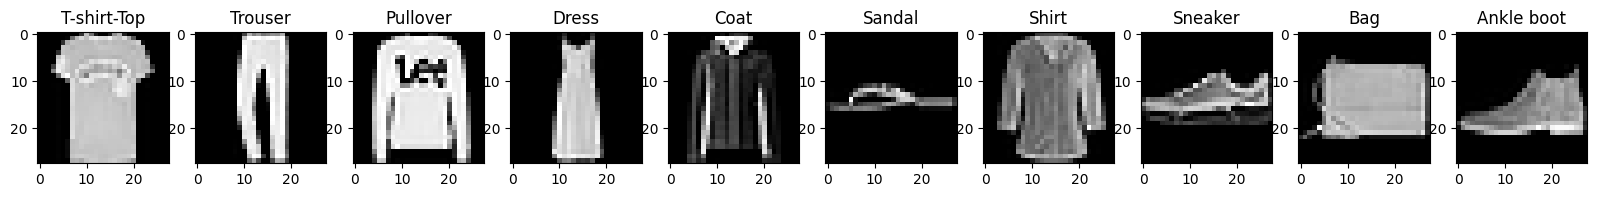

In [ ]:
labeldict = {
    0: 'T-shirt-Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

items_train = []
items_test = []

for i in range(10):
  items_train.append([])
  items_test.append([])
  for j in range(len(x_train)):
    if y_train[j]==i:
      items_train[i].append(x_train[j])
  for j in range(len(x_test)):
    if y_test[j]==i:
      items_test[i].append(x_test[j])

fig, ax = plt.subplots(1, 10, figsize=(20, 2))

# for i in range(10):
    # ax[i].imshow(x_train[i], cmap='gray')
    # ax[i].set_title(labeldict[y_train[i]])

for i in range(10):
    ax[i].imshow(items_test[i][0], cmap='gray')
    ax[i].set_title(labeldict[i])

In [ ]:
# Klasa która pozwala tworzyć autoenkoder o wybranym poziomie kompresji
class Dense_autoencoder:
    def __init__(self, x_train, x_test, y_train, y_test, name, cut_shape):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.name = name
        self.cut_shape = cut_shape
        self.input = Input(shape=(28, 28, 1))
        self.model, self.encoder, self.decoder = self.build_model(cut_shape)

    def build_model(self, cut_shape):
        #building encoder
        inputs = self.input
        inputs = Input(shape=(28, 28, 1))

        x = Flatten()(inputs)
        x = Dense(28*28, activation='relu')(x)
        x = LeakyReLU()(x)
        x = Dense(400, activation='relu')(x)
        x = LeakyReLU()(x)
        x = Dense(200, activation='relu')(x)
        x = LeakyReLU()(x)
        x = Dense(156, activation='relu')(x)
        x = LeakyReLU()(x)
        encoded = Dense(cut_shape, activation='relu')(x)

        encoder = Model(inputs=inputs, outputs=encoded)
        encoded_inputs = Input(shape=(cut_shape,))

        x = Dense(cut_shape, activation='relu')(encoded_inputs)
        x = Dense(156, activation='relu')(x)
        x = LeakyReLU()(x)
        x = Dense(200, activation='relu')(x)
        x = LeakyReLU()(x)
        x = Dense(400, activation='relu')(x)
        x = LeakyReLU()(x)
        x = Dense(28*28, activation='relu')(x)
        decoded = Reshape((28, 28, 1))(x)

        decoder = Model(inputs=encoded_inputs, outputs=decoded)

        def psnr(y_true, y_pred):
          mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
          psnr = 10 * tf.experimental.numpy.log10(1.0 / tf.math.sqrt(mse))
          return psnr

        x = encoder(inputs)
        x = decoder(x)
        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse', psnr, 'mae'])

        print(model.summary())

        clr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

        model.fit(
            x_train,
            x_train,
            batch_size=256,
            epochs=30,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=[clr])

            # Zapisywanie modelu

        folder = os.path.join(folder_base, "Dense", str(cut_shape))

        print("Saving autoencoder")
        model_path = os.path.join(folder, "model.h5")
        model.save(model_path)

        print("Saving encoder")
        encoder_path = os.path.join(folder, "encoder.h5")
        encoder.save(encoder_path)

        print("Saving decoder")
        decoder_path = os.path.join(folder, "decoder.h5")
        decoder.save(decoder_path)

        history_path = os.path.join(folder, "history.csv")
        with open(history_path, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Accuracy", "MSE", "VAL_MSE", "PSNR", "VAL_PSNR", "MAE", "VAL_MAE"])
            for i, loss in enumerate(model.history.history['loss']):
                epoch = i + 1
                acc = model.history.history['accuracy'][i]
                mse = model.history.history['mse'][i]
                val_mse = model.history.history['val_mse'][i]
                psnr = model.history.history['psnr'][i]
                val_psnr = model.history.history['val_psnr'][i]
                mae = model.history.history['mae'][i]
                val_mae = model.history.history['val_mae'][i]
                writer.writerow([epoch, loss, acc, mse, val_mse, psnr, val_psnr, mae, val_mae])

        return model, encoder, decoder

    def plot_image_reconstructions(self, all_index, items_per_category):
        # Wyświetlanie obrazów i macierzy liczbowych
        fig, axs = plt.subplots(2, 10 * items_per_category, figsize=(30 * items_per_category/2, 6))
        all_encoded = []
        mse_values = []
        psnr_values = []
        # Wyświetlanie obrazu przed enkoderem
        for i in range(10):
            for j in range(items_per_category):
              # Przekształcanie obrazu przez modele enkodera i dekodera
              input_image = items_test[i][all_index[i][0][j]]
              encoded_image = self.encoder.predict(np.expand_dims(input_image, axis=0))
              decoded_image = self.decoder.predict(encoded_image)

              # Pobieranie rozmiarów skompresowanych obrazów
              input_shape = input_image.shape[:2]
              encoded_shape = encoded_image.shape

              fig.suptitle(f'Dense autoencoder - {self.cut_shape}', fontsize=16)

              # Wyświetlanie obrazu po dekoderze
              axs[0, i * items_per_category + j].imshow(input_image, cmap='gray')
              axs[0, i * items_per_category + j].set_title(labeldict[i])
              axs[0, i * items_per_category + j].axis('off')

              # Wyświetlanie obrazu po dekoderze
              axs[1, i * items_per_category + j].imshow(decoded_image.squeeze(), cmap='gray')
              axs[1, i * items_per_category + j].axis('off')

              all_encoded.append([encoded_image, i, j])
              mse = mean_squared_error(input_image, decoded_image.squeeze())
              psnr = 10 * math.log10(1. / math.sqrt(mse))
              mse_values.append(mse)
              psnr_values.append(psnr)

        plt.tight_layout()
        plt.show()

        folder = os.path.join(folder_base, "Dense", str(self.cut_shape), "Encoded")

        print("Encoded output")
        for i in range(len(all_encoded)) :
          print(f"Image {i+1} before decoder:")
          print(f"MSE: {mse_values[i]}")
          print(f"PSNR: {psnr_values[i]}")

          encoded_path = os.path.join(folder, labeldict[all_encoded[i][1]] + str(all_encoded[i][2]) + ".txt")
          os.makedirs(os.path.dirname(encoded_path), exist_ok=True)
          with open(encoded_path, mode='w') as file:
              file.write(str(all_encoded[i][0]))

    def apply_autoencoder(self, dataset):
        encoded_dataset = self.encoder.predict(dataset)
        decoded_dataset = self.decoder.predict(encoded_dataset)
        return decoded_dataset



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 156)               1065488   
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         475168    
                                                                 
Total params: 1,540,656
Trainable params: 1,540,656
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
235/235 [==============================] - 7s 9ms/step - loss: 0.8506 - accuracy: 0.4951 - mse: 0.0721 - psnr: inf - mae: 0.1755 - val_loss: 0.6070 - val_accuracy: 0.4942 - val_mse: 0.0515 - val_psnr: inf - val_mae: 0.1387 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - 1s 6ms/

Saving encoder


Saving decoder
1/1 [==============================] - 0s 19ms/step


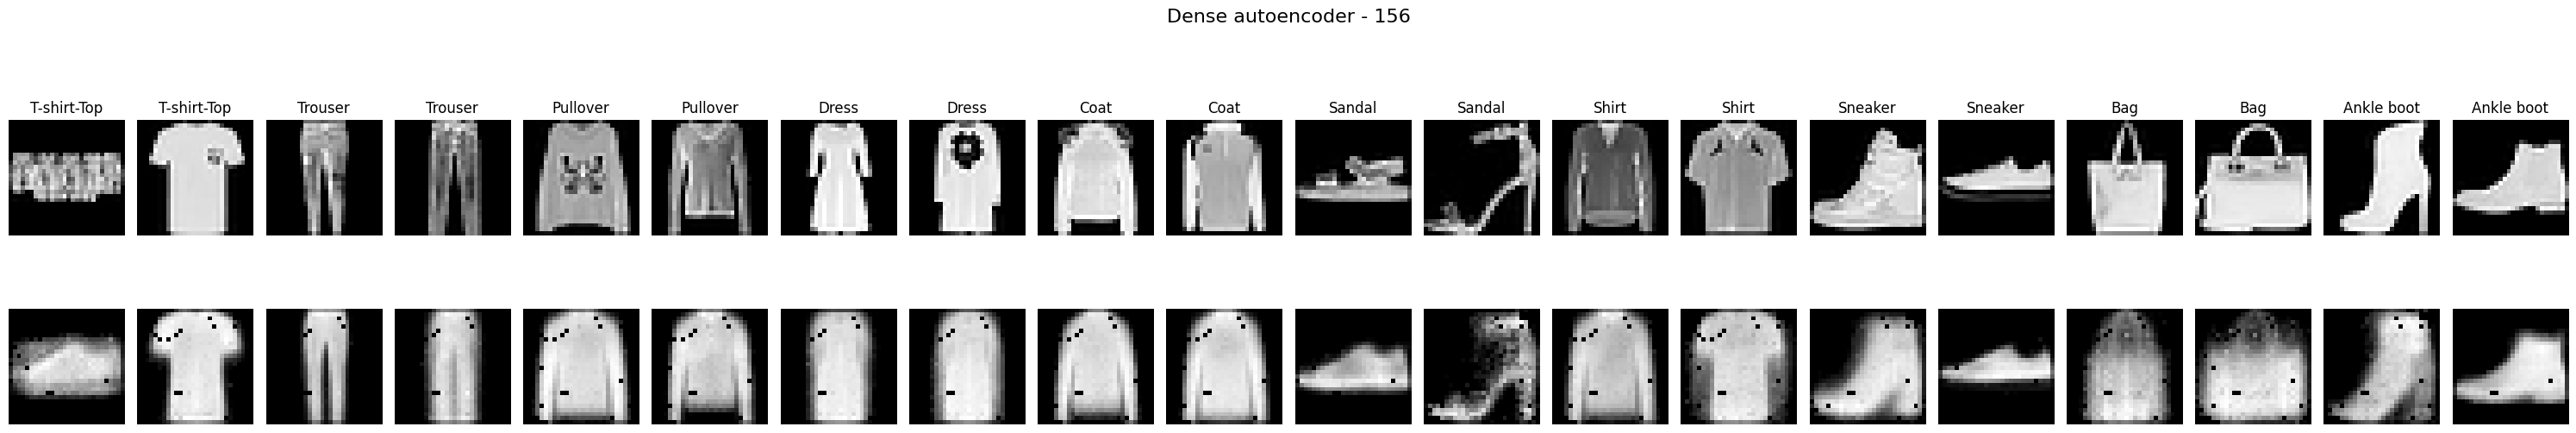

Encoded output
Image 1 before decoder:
MSE: 0.03212713520403575
PSNR: 7.465639995110271
Image 2 before decoder:
MSE: 0.02245404258547034
PSNR: 8.243527290116466
Image 3 before decoder:
MSE: 0.017628962297909327
PSNR: 8.768866255166898
Image 4 before decoder:
MSE: 0.025614494351785207
PSNR: 7.957571064914579
Image 5 before decoder:
MSE: 0.025327927991455917
PSNR: 7.9820016860026035
Image 6 before decoder:
MSE: 0.03057389694439892
PSNR: 7.57324601317586
Image 7 before decoder:
MSE: 0.033313518822311386
PSNR: 7.386897457318721
Image 8 before decoder:
MSE: 0.056983370587052225
PSNR: 6.221259328302669
Image 9 before decoder:
MSE: 0.030884124650208764
PSNR: 7.551323516875318
Image 10 before decoder:
MSE: 0.032013583635378304
PSNR: 7.473328538689402
Image 11 before decoder:
MSE: 0.01774274163628092
PSNR: 8.754896357270399
Image 12 before decoder:
MSE: 0.038290005978802145
PSNR: 7.084572829196456
Image 13 before decoder:
MSE: 0.01487156369908398
PSNR: 9.138216821754947
Image 14 before decoder:

Saving autoencoder
Saving encoder
Saving decoder
1/1 [==============================] - 0s 22ms/step


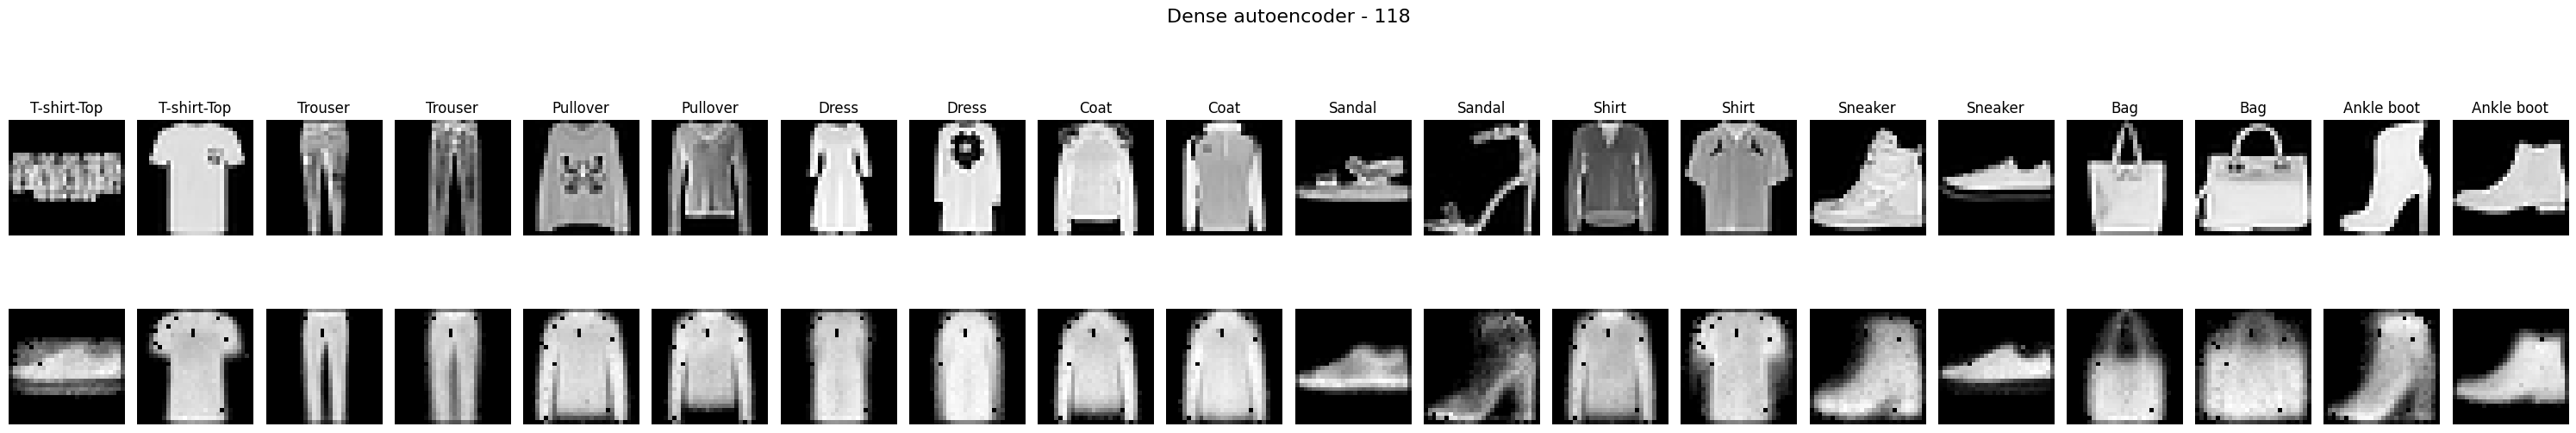

Encoded output
Image 1 before decoder:
MSE: 0.033243198412848264
PSNR: 7.391485991493402
Image 2 before decoder:
MSE: 0.020646744748869832
PSNR: 8.425742056368419
Image 3 before decoder:
MSE: 0.016930298861577934
PSNR: 8.85667687726733
Image 4 before decoder:
MSE: 0.02015276637864322
PSNR: 8.478326648230755
Image 5 before decoder:
MSE: 0.026640145224409512
PSNR: 7.8723170600485135
Image 6 before decoder:
MSE: 0.027341341956195118
PSNR: 7.815900866933926
Image 7 before decoder:
MSE: 0.030690027149500514
PSNR: 7.565013636877537
Image 8 before decoder:
MSE: 0.05818361031594149
PSNR: 6.175996670545807
Image 9 before decoder:
MSE: 0.027496513917162603
PSNR: 7.803611818577659
Image 10 before decoder:
MSE: 0.03077916207857871
PSNR: 7.558716037143055
Image 11 before decoder:
MSE: 0.0160349703709146
PSNR: 8.97465919107564
Image 12 before decoder:
MSE: 0.041348419373247125
PSNR: 6.91770543788452
Image 13 before decoder:
MSE: 0.014897403309921817
PSNR: 9.134447123190549
Image 14 before decoder:
M

Saving autoencoder
Saving encoder
Saving decoder
1/1 [==============================] - 0s 27ms/step


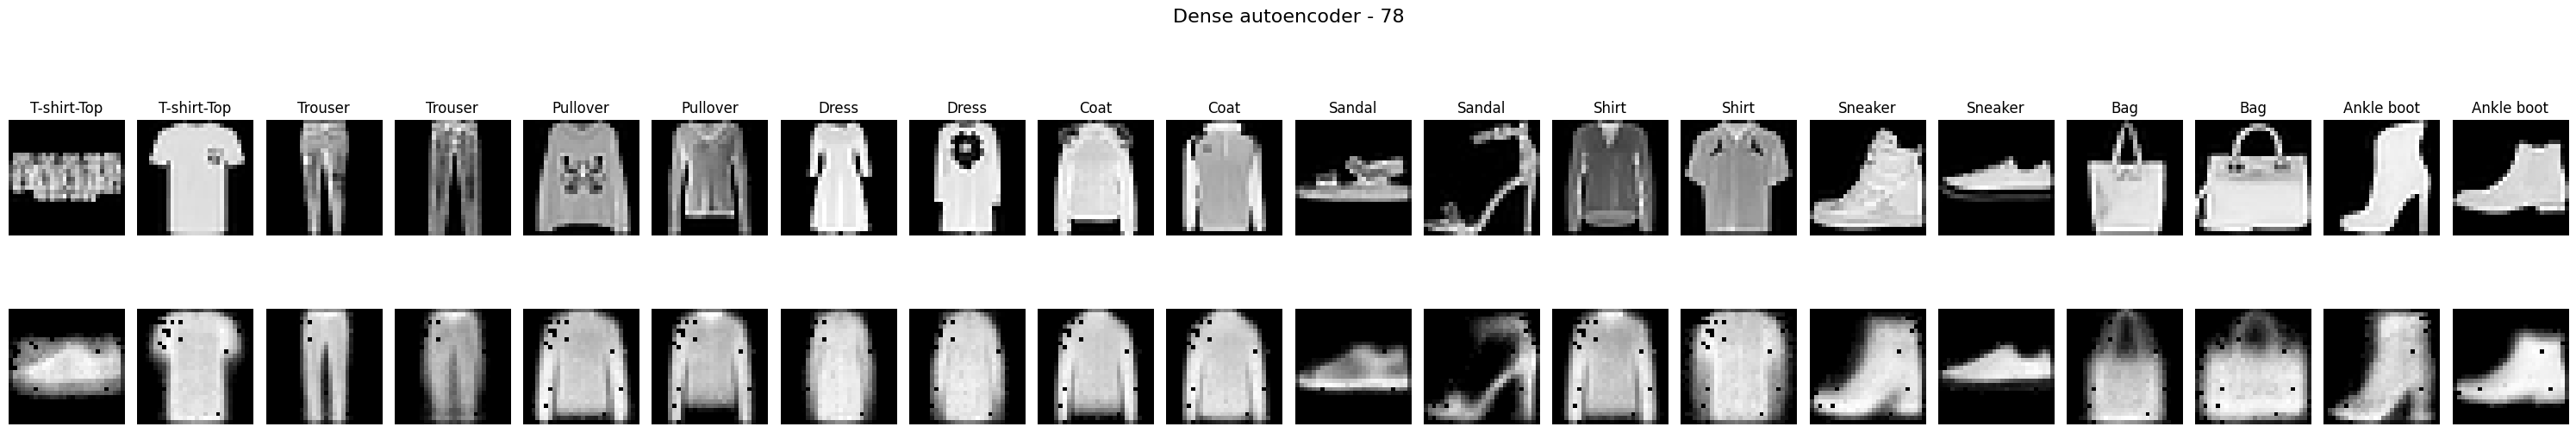

Encoded output
Image 1 before decoder:
MSE: 0.0284294656933815
PSNR: 7.73115651206425
Image 2 before decoder:
MSE: 0.024628550676963852
PSNR: 8.042805722273615
Image 3 before decoder:
MSE: 0.01681324171822201
PSNR: 8.871742716382657
Image 4 before decoder:
MSE: 0.020394917833430937
PSNR: 8.452390200094184
Image 5 before decoder:
MSE: 0.026146519208134652
PSNR: 7.912930595038628
Image 6 before decoder:
MSE: 0.03006772995596738
PSNR: 7.609496794451099
Image 7 before decoder:
MSE: 0.04007062450473859
PSNR: 6.985869444955494
Image 8 before decoder:
MSE: 0.0598612997456026
PSNR: 6.114269288613872
Image 9 before decoder:
MSE: 0.028992246192412318
PSNR: 7.688590680524099
Image 10 before decoder:
MSE: 0.03048807083311509
PSNR: 7.579350276178908
Image 11 before decoder:
MSE: 0.014531977167284434
PSNR: 9.188376465872299
Image 12 before decoder:
MSE: 0.033037919089500864
PSNR: 7.404936573769082
Image 13 before decoder:
MSE: 0.014891359984840587
PSNR: 9.135328187887717
Image 14 before decoder:
MSE

Saving encoder
Saving decoder
1/1 [==============================] - 0s 17ms/step


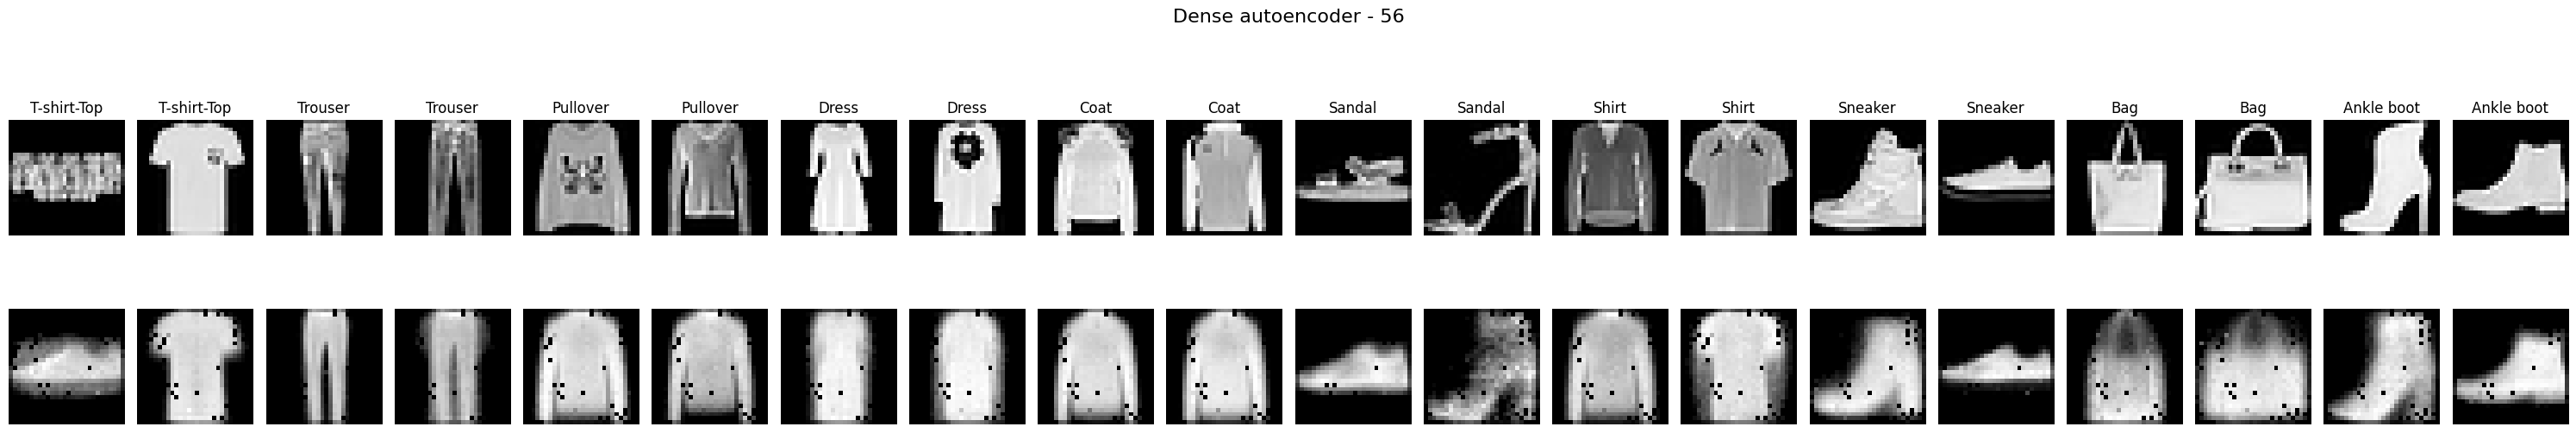

Encoded output
Image 1 before decoder:
MSE: 0.03174007001424751
PSNR: 7.491960597929827
Image 2 before decoder:
MSE: 0.027838780142940674
PSNR: 7.776748994157316
Image 3 before decoder:
MSE: 0.015339504860311857
PSNR: 9.070943293168842
Image 4 before decoder:
MSE: 0.020844777063185233
PSNR: 8.405013726662085
Image 5 before decoder:
MSE: 0.02833562637459901
PSNR: 7.7383359129904505
Image 6 before decoder:
MSE: 0.03128288537418646
PSNR: 7.5234659832566395
Image 7 before decoder:
MSE: 0.03310561959138234
PSNR: 7.40049139813393
Image 8 before decoder:
MSE: 0.061380879717292954
PSNR: 6.0598344575245555
Image 9 before decoder:
MSE: 0.03852026125187687
PSNR: 7.07155388034087
Image 10 before decoder:
MSE: 0.03554344221493102
PSNR: 7.246202575596886
Image 11 before decoder:
MSE: 0.020442068262446038
PSNR: 8.44737582900618
Image 12 before decoder:
MSE: 0.05103906405301063
PSNR: 6.4604864912169715
Image 13 before decoder:
MSE: 0.015554234362638125
PSNR: 9.040756808107474
Image 14 before decoder:


Saving autoencoder
Saving encoder
Saving decoder
1/1 [==============================] - 0s 28ms/step


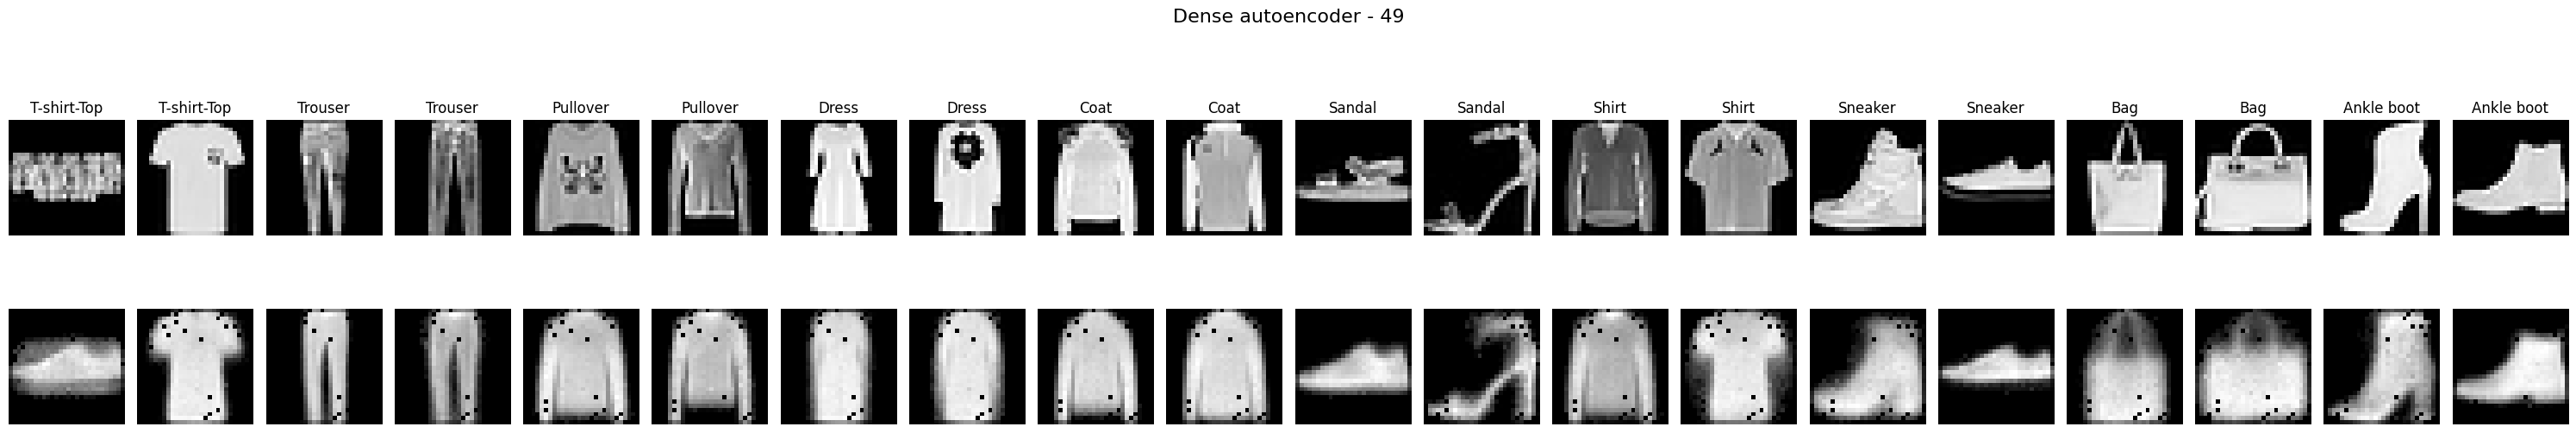

Encoded output
Image 1 before decoder:
MSE: 0.030046670017069343
PSNR: 7.611018262789951
Image 2 before decoder:
MSE: 0.02487772137754581
PSNR: 8.020947002236614
Image 3 before decoder:
MSE: 0.019623572178784583
PSNR: 8.536109664616394
Image 4 before decoder:
MSE: 0.01821292710565936
PSNR: 8.6981012529921
Image 5 before decoder:
MSE: 0.02770202903014577
PSNR: 7.7874420997457
Image 6 before decoder:
MSE: 0.028237168774883952
PSNR: 7.745894251820293
Image 7 before decoder:
MSE: 0.036119487899562354
PSNR: 7.211292078610329
Image 8 before decoder:
MSE: 0.055412603699859224
PSNR: 6.281957214737849
Image 9 before decoder:
MSE: 0.02561015265375061
PSNR: 7.957939164181877
Image 10 before decoder:
MSE: 0.03406454209923827
PSNR: 7.338487222689505
Image 11 before decoder:
MSE: 0.019758646248306373
PSNR: 8.521214070763886
Image 12 before decoder:
MSE: 0.038798645837316084
PSNR: 7.055917160127446
Image 13 before decoder:
MSE: 0.015037946410536898
PSNR: 9.114057335831506
Image 14 before decoder:
MSE

Saving autoencoder
Saving encoder
Saving decoder
1/1 [==============================] - 0s 20ms/step


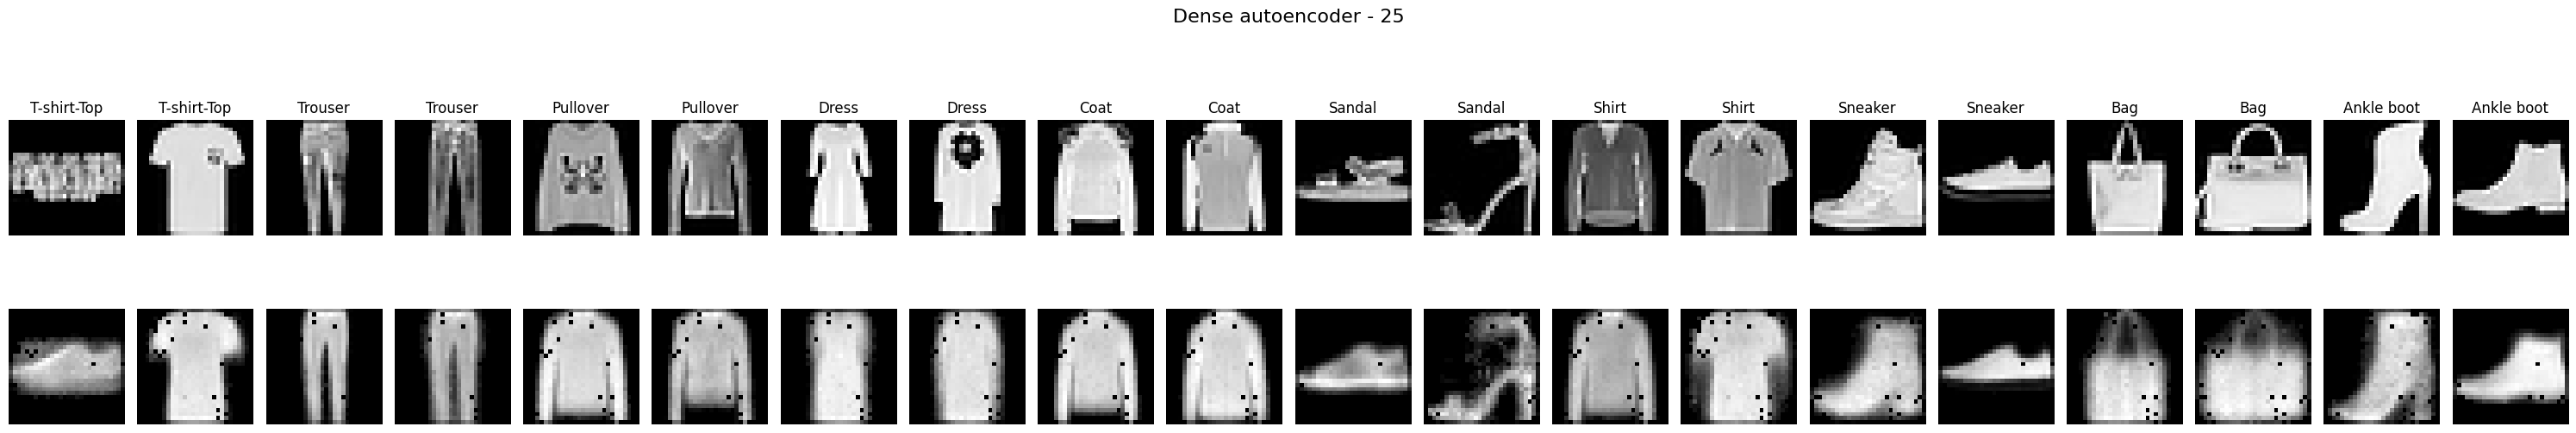

Encoded output
Image 1 before decoder:
MSE: 0.029177917774793203
PSNR: 7.674728519578049
Image 2 before decoder:
MSE: 0.021333180306209017
PSNR: 8.354721980024353
Image 3 before decoder:
MSE: 0.01677771808244218
PSNR: 8.876335536843648
Image 4 before decoder:
MSE: 0.018322393242266533
PSNR: 8.685089000495129
Image 5 before decoder:
MSE: 0.026445322943189097
PSNR: 7.888255625624563
Image 6 before decoder:
MSE: 0.027406552548901914
PSNR: 7.810727953121739
Image 7 before decoder:
MSE: 0.03443002972268346
PSNR: 7.3153130118917
Image 8 before decoder:
MSE: 0.056919116915703775
PSNR: 6.223709232468982
Image 9 before decoder:
MSE: 0.031073744900069013
PSNR: 7.538032019623437
Image 10 before decoder:
MSE: 0.03494824506840295
PSNR: 7.282873137680815
Image 11 before decoder:
MSE: 0.0164894365561973
PSNR: 8.913970919689788
Image 12 before decoder:
MSE: 0.03418870198201267
PSNR: 7.330586937191404
Image 13 before decoder:
MSE: 0.015313122344972419
PSNR: 9.074681238234103
Image 14 before decoder:
MS

Saving autoencoder
Saving encoder
Saving decoder
1/1 [==============================] - 0s 29ms/step


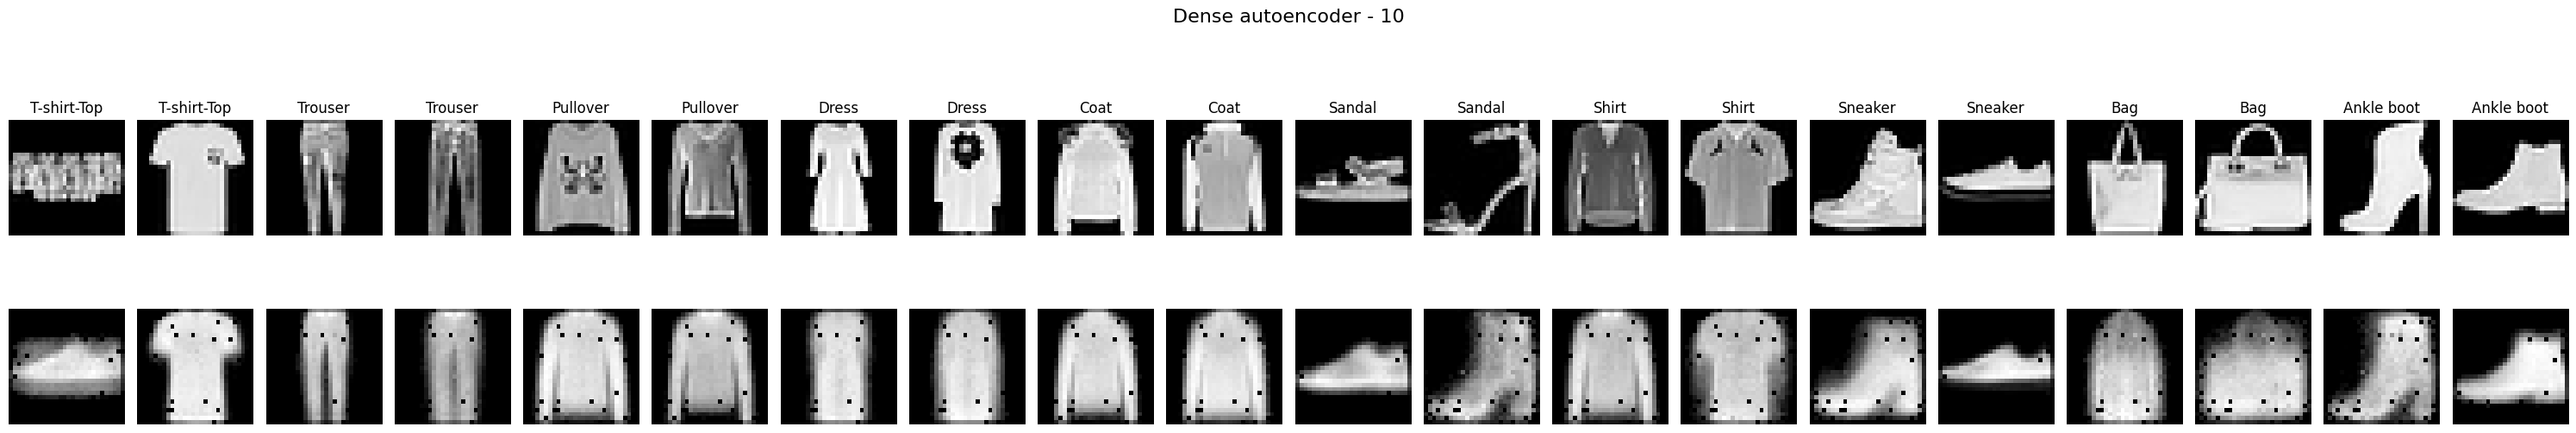

Encoded output
Image 1 before decoder:
MSE: 0.031787470502027855
PSNR: 7.488720149151952
Image 2 before decoder:
MSE: 0.021732987200213546
PSNR: 8.314402878888327
Image 3 before decoder:
MSE: 0.01743287210329989
PSNR: 8.793155280210765
Image 4 before decoder:
MSE: 0.022635006958722403
PSNR: 8.22609683826373
Image 5 before decoder:
MSE: 0.029111415155359862
PSNR: 7.6796834112763435
Image 6 before decoder:
MSE: 0.028727491498442233
PSNR: 7.708511476017945
Image 7 before decoder:
MSE: 0.03602969726236714
PSNR: 7.216696934993011
Image 8 before decoder:
MSE: 0.061106033490974224
PSNR: 6.069579531236475
Image 9 before decoder:
MSE: 0.02978617064244276
PSNR: 7.629926633934039
Image 10 before decoder:
MSE: 0.033520819462697526
PSNR: 7.373426864919793
Image 11 before decoder:
MSE: 0.018959359825218423
PSNR: 8.610881654891893
Image 12 before decoder:
MSE: 0.061975273994436864
PSNR: 6.038907722638626
Image 13 before decoder:
MSE: 0.015680980282627023
PSNR: 9.023133956335634
Image 14 before decode

In [ ]:
# Tworzenie obiektów dla różnych wartości compression_level
dense_cut = [156, 118, 78, 56, 49, 25, 10, 4]
autoencoders = []

# Wybieranie losowych indeksów obrazów testowych - po 2 dla każdej klasy
num_samples = 2
all_indexes = []
for i in range(10):
  all_indexes.append([])
  all_indexes[i].append(random.sample(range(len(items_test[i])), num_samples))

for cut in dense_cut:
    autoencoder = Dense_autoencoder(x_train, x_test, y_train, y_test, f"Dense_autoencoder_{cut}", cut)
    autoencoder.plot_image_reconstructions(all_indexes, num_samples)
    autoencoders.append(autoencoder)